# Calculate ngal vs systematics for contaminated mocks

In [ ]:
#%pip install healpy

In [1]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')

from lssutils.lab import get_meandensity
from lssutils.dataviz import mollview

In [2]:
import sys
sys.path.append("/global/homes/a/arosado/")
from prepare_data import prepare_LRGmock_data, maps_dr9, hpixsum
from astropy.table import Table, vstack

import os
import utils as ut
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cscratch = '/global/cscratch1/sd/arosado/'
plot_dir = ''

In [4]:
nside=256

# read data used for NN
tables = vstack([Table.read(f'/global/cscratch1/sd/arosado/nlrg_features_{r}_256.fits', format='fits') for r in ['bmzls', 'ndecals', 'sdecals']])
ngal = tables['label']
nran = tables['fracgood']
mask = np.ones_like(ngal, '?')
sysm = tables['features']
#hpix = tables['hpix']

# read systematics
concat_sysm = vstack([Table.read(f'{cscratch}rands/rongpu_imaging_maps/pixmap_{r}_nside_256_minobs_1_maskbits_1111213.fits', format='fits') for r in ['north','south']])
#edmond_sysm = Table.read("/global/homes/a/arosado/regressis/regressis/tests/test_data/pixweight-dr9-256.fits",format='fits')
# get NN-weights
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits')

/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [10]:
np.percentile(nn_test1, [0,1,99,100])

array([-1.63750000e+30, -1.63750000e+30,  3.40300954e+01,  4.69786867e+01])

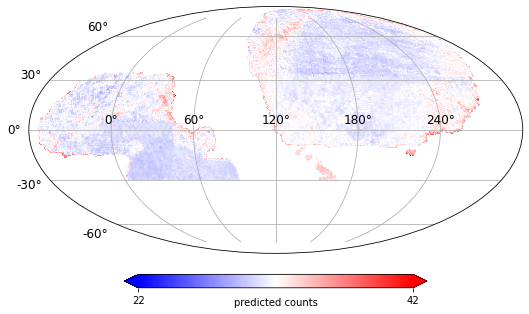

In [5]:
mollview(nn_test1, 22, 42, 'predicted counts', colorbar=True)

In [5]:
%%time
norm_method = 'mean'
downsampling= 'frac'
# get uncontaminated mock and contaminated mock (contaminated mock by downsampling), and project them to healpix maps
mock_uncont, mock_uncont_pix_number = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                                                  tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0, return_hpix=True)
mock_uncont_hmap = ut.project2hp(nside, mock_uncont)
#uncont_mask = ut.make_hp(1.0, mock_uncont_pix_number, nside) > 0.5

mock_cont, mock_cont_pix_number = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                                              tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0, return_hpix=True)
mock_cont_hmap = ut.project2hp(nside, mock_cont)

# collect randoms
randoms_path = '/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_random_S1000_1X.fits'
randoms = ut.apply_mock_mask(randoms_path, main=0, nz=0, Y5=1, sv3=0)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
using frac when downsampling
applying mask: main=0, nz=0, Y5=1, sv3=0
CPU times: user 43.5 s, sys: 21.5 s, total: 1min 5s
Wall time: 1min 5s


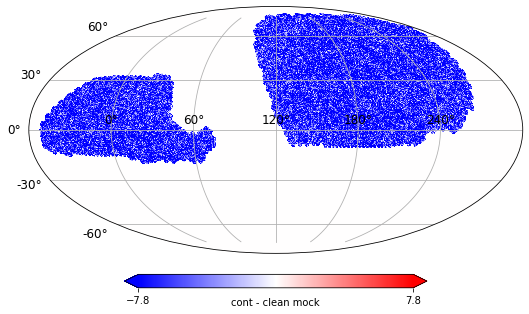

In [7]:
data = mock_cont
zmin, zmax = 0.6, 0.8
good = (data['Z'] > zmin) & (data['Z'] < zmax)
m = hpixsum(256, data['RA'][good], data['DEC'][good])

data1 = mock_uncont
zmin, zmax = 0.6, 0.8
good = (data1['Z'] > zmin) & (data1['Z'] < zmax)
m1 = hpixsum(256, data1['RA'][good], data1['DEC'][good])

dm = m - m1

maxx = abs(dm[dm!=0].min())
mollview(dm*1.0, -.2*maxx, .2*maxx , 'cont - clean mock', colorbar=True)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 4.00000e+00, 7.90000e+01,
        3.40800e+03, 6.10010e+04, 1.26763e+05, 8.59270e+04, 2.81360e+04,
        8.99700e+03, 3.43900e+03, 1.58000e+03, 6.24000e+02, 2.61000e+02,
        9.80000e+01, 3.50000e+01, 1.50000e+01, 4.00000e+00, 7.00000e+00,
        4.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.62839576, 0.65718881, 0.68598186, 0.71477492, 0.74356797,
        0.77236102, 0.80115407, 0.82994713, 0.85874018, 0.88753323,
        0.91632629, 0.94511934, 0.97391239, 1.00270544, 1.0314985 ,
        1.06029155, 1.0890846 , 1.11787766, 1.14667071, 1.17546376,
        1.20425681, 1.23304987, 1.26184292, 1.29063597, 1.31942903,
        1.34822208, 1.37701513, 1.40580818, 1.43460124, 1.46339429,
        1.49218734]),
 <BarContainer object of 30 artists>)

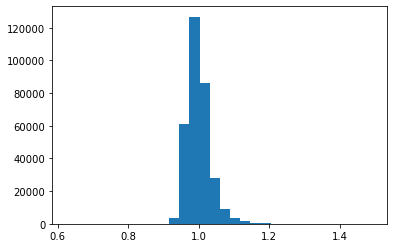

In [40]:
plt.hist(nn_test1[nn_test1!=hp.UNSEEN]/nn_test1[nn_test1!=hp.UNSEEN].mean(), bins=30)

In [37]:
from glob import glob

In [38]:
t = '_test1'
nside = 256
windows = glob(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean{t}/nnwindow_*.hp{nside}.fits')
windows[:5], len(windows)

(['/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nnwindow_265.hp256.fits',
  '/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nnwindow_282.hp256.fits',
  '/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nnwindow_134.hp256.fits',
  '/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nnwindow_5.hp256.fits',
  '/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nnwindow_233.hp256.fits'],
 336)

In [41]:
dd = hp.read_map(windows[0])

/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 256
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/a/arosado/.conda/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


(array([3.00000e+00, 2.00000e+00, 4.00000e+00, 6.00000e+00, 1.30000e+01,
        2.50000e+01, 7.70000e+01, 9.70000e+01, 1.10000e+02, 1.45000e+02,
        3.94000e+02, 3.81400e+03, 2.98690e+04, 4.60720e+04, 5.15690e+04,
        1.15223e+05, 5.74370e+04, 1.11620e+04, 2.90600e+03, 8.95000e+02,
        3.41000e+02, 6.40000e+01, 1.10000e+01, 7.00000e+00, 8.00000e+00,
        0.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
        1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
        1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
        1.5       ]),
 <BarContainer object of 30 artists>)

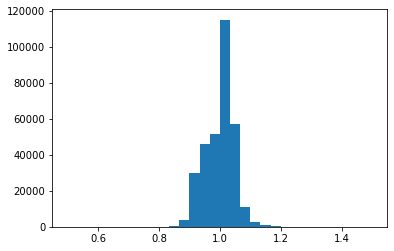

In [44]:
plt.hist(dd[dd!=hp.UNSEEN]/dd[dd!=hp.UNSEEN].mean(), bins=30, range=(0.5, 1.5))

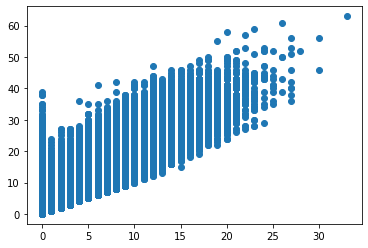

In [8]:
plt.scatter(m, m1)

In [15]:
np.percentile(m,[0,1,99,100] )

array([ 0.,  0., 28., 63.])

In [26]:
%%time
#maps =['STARDENS', 'EBV',
#       'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z',
#       'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
#       'PSFDEPTH_W1', 'PSFDEPTH_W2'] 
maps = maps_dr9

systematics = concat_sysm #edmond_sysm
hp_order = 'ring' # hpix ordering used in systematics file
zmin, zmax = 0.4,1.1 # 0.8, 1.1
 
def mock_meandensity(mock, randoms, systematics, hp_order, maps, zmin=zmin, zmax=zmax, nside=256, selection_fn=None, binning='equi-area',
                    njack=20):
    
    prep_data = prepare_LRGmock_data(mock, randoms, systematics, hp_order=hp_order, zmin=zmin, zmax=zmax, nside=nside, columns=maps)
    ngal = prep_data['label']
    nran = prep_data['fracgood']
    mask = np.ones_like(prep_data['label'], '?')
    sysm = prep_data['features']
    #hpix = prep_data['hpix']

    nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                                 columns=maps, selection_fn=selection_fn, binning=binning, percentiles=[1, 99],
                                 global_nbar=True, njack=njack)
    return nnbar_list, prep_data


#nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
#                             columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
#                             global_nbar=True, njack=20)

nnbar_list_uncont, prep_data_uncont = mock_meandensity(mock_uncont, randoms, systematics, hp_order, maps)
nnbar_list_cont, prep_data_cont = mock_meandensity(mock_cont, randoms, systematics, hp_order, maps)

.............preparing randoms
cleaning randoms
preparing data
cleaning data
.............preparing randoms
cleaning randoms
preparing data
cleaning data
CPU times: user 1min 17s, sys: 3.57 s, total: 1min 20s
Wall time: 1min 20s


In [27]:
m_uncont = ut.make_hp(prep_data_uncont['label'], prep_data_uncont['hpix'], nside)
m_cont = ut.make_hp(prep_data_cont['label'], prep_data_cont['hpix'], nside)

In [28]:
print(np.percentile(m_cont[m_cont>0], [0,1,99,100]))

[ 1.  9. 43. 67.]


In [29]:
np.percentile(m_uncont[m_uncont>0], [0,1,99,100])

array([  1.,  35., 117., 178.])

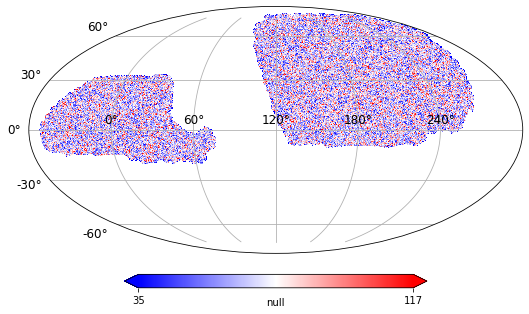

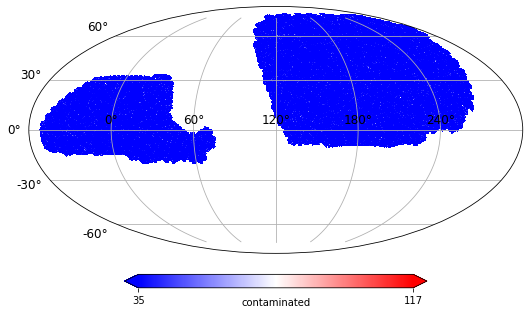

In [30]:
mollview(m_uncont,35, 117, 'null', colorbar=True)
mollview(m_cont, 35, 117, 'contaminated', colorbar=True)

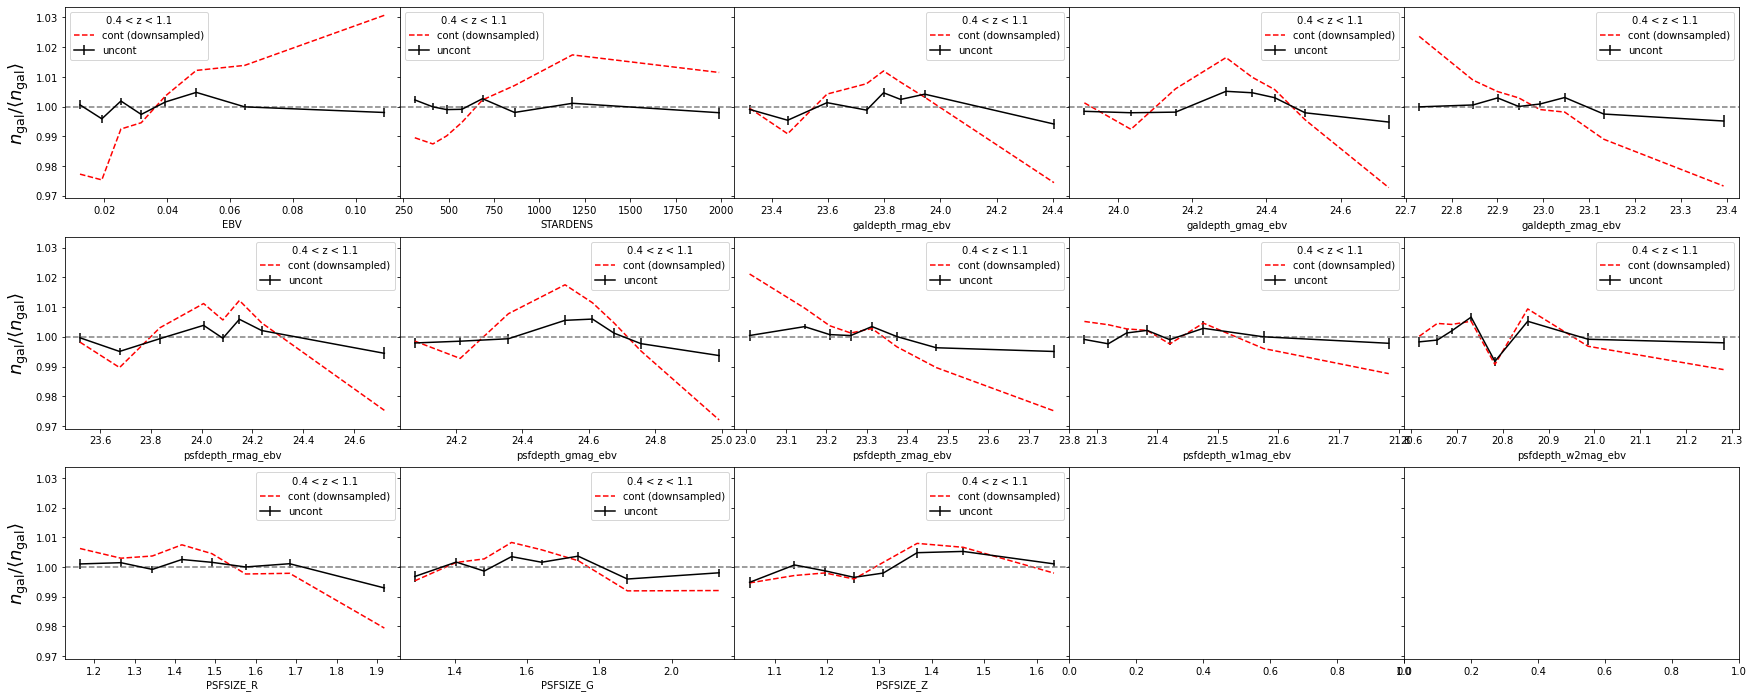

CPU times: user 2.33 s, sys: 444 ms, total: 2.77 s
Wall time: 2.55 s


In [31]:
%%time
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.2)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    #ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], ls='--', color='k', label='LRG data')
    ax[col_i].errorbar(nnbar_list_uncont[col_i]['bin_avg'], nnbar_list_uncont[col_i]['nnbar'], nnbar_list_uncont[col_i]['nnbar_err'], color='k', label='uncont')
    ax[col_i].plot(nnbar_list_cont[col_i]['bin_avg'], nnbar_list_cont[col_i]['nnbar'], color='r',ls='--', label='cont (downsampled)')
    ax[col_i].legend(title=f'{zmin} < z < {zmax}')
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
#ax[0].set_ylim(1.00-0.2, 1.00+0.2)
#fn = os.path.join(plot_dir, f'LRG_density_variations_rongpumaps_lowzbin_percentile_normalization.png')
fn = os.path.join(plot_dir, f'LRG_density_variations_rongpumaps_mainzbin_percentile_normalization.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

In [32]:
%%time

nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=maps, selection_fn=None, binning='equi-area', percentiles=[1, 99],
                             global_nbar=True, njack=20)

CPU times: user 38.5 s, sys: 239 ms, total: 38.7 s
Wall time: 38.7 s


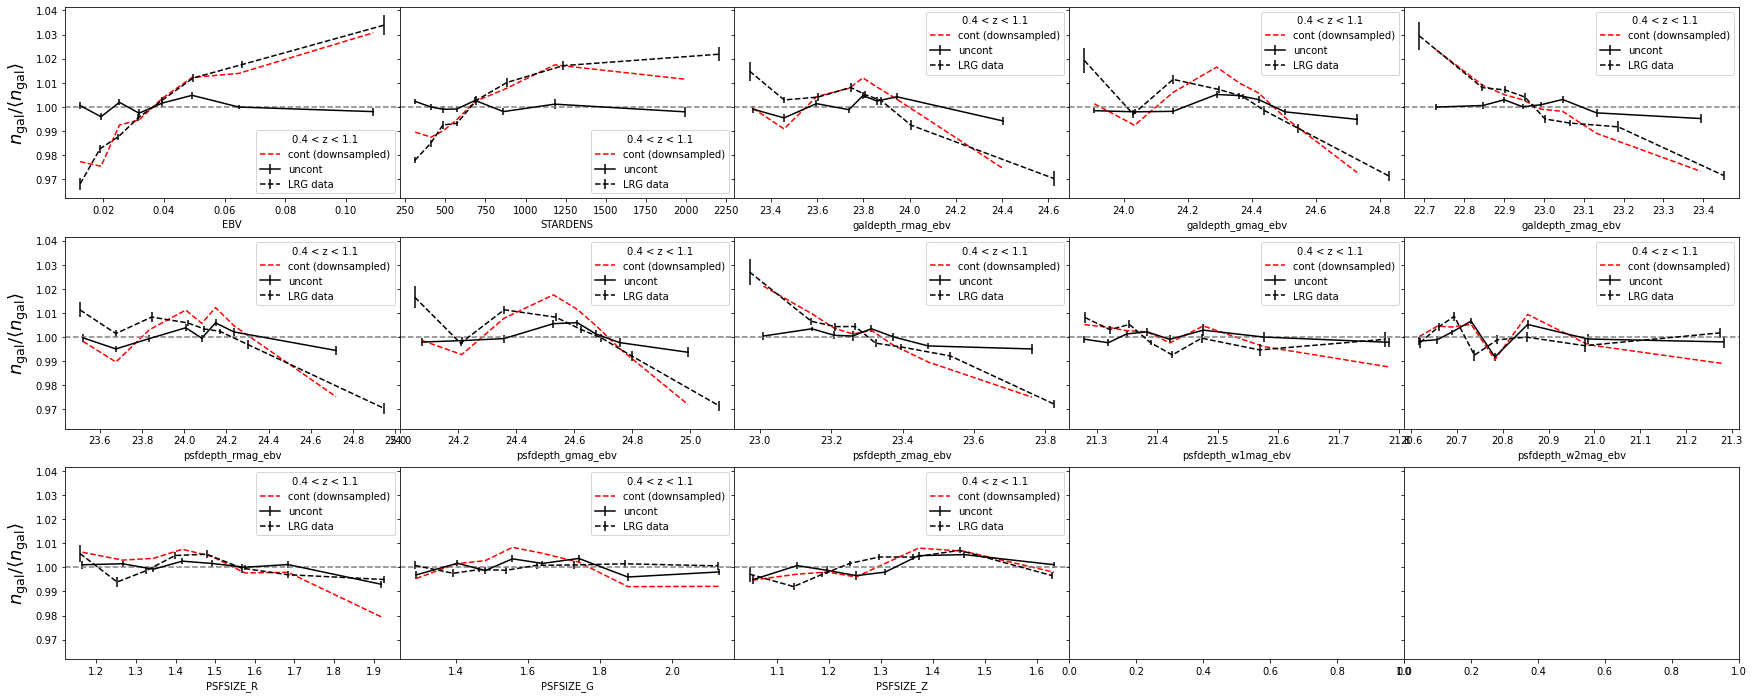

CPU times: user 4.98 s, sys: 1.03 s, total: 6.01 s
Wall time: 5.6 s


In [33]:
%%time
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.2)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    #ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], ls='--', color='k', label='LRG data')
    ax[col_i].errorbar(nnbar_list_uncont[col_i]['bin_avg'], nnbar_list_uncont[col_i]['nnbar'], nnbar_list_uncont[col_i]['nnbar_err'], color='k', label='uncont')
    ax[col_i].plot(nnbar_list_cont[col_i]['bin_avg'], nnbar_list_cont[col_i]['nnbar'], color='r',ls='--', label='cont (downsampled)')
    ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], ls='--', color='k', label='LRG data')
    ax[col_i].legend(title=f'{zmin} < z < {zmax}')
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
#ax[0].set_ylim(1.00-0.2, 1.00+0.2)
#fn = os.path.join(plot_dir, f'LRG_density_variations_rongpumaps_mainzbin_percentile_normalization.png')
fn = os.path.join(plot_dir, f'LRG_density_variations_rongpumaps_lowzbin_frac_downsampling.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()

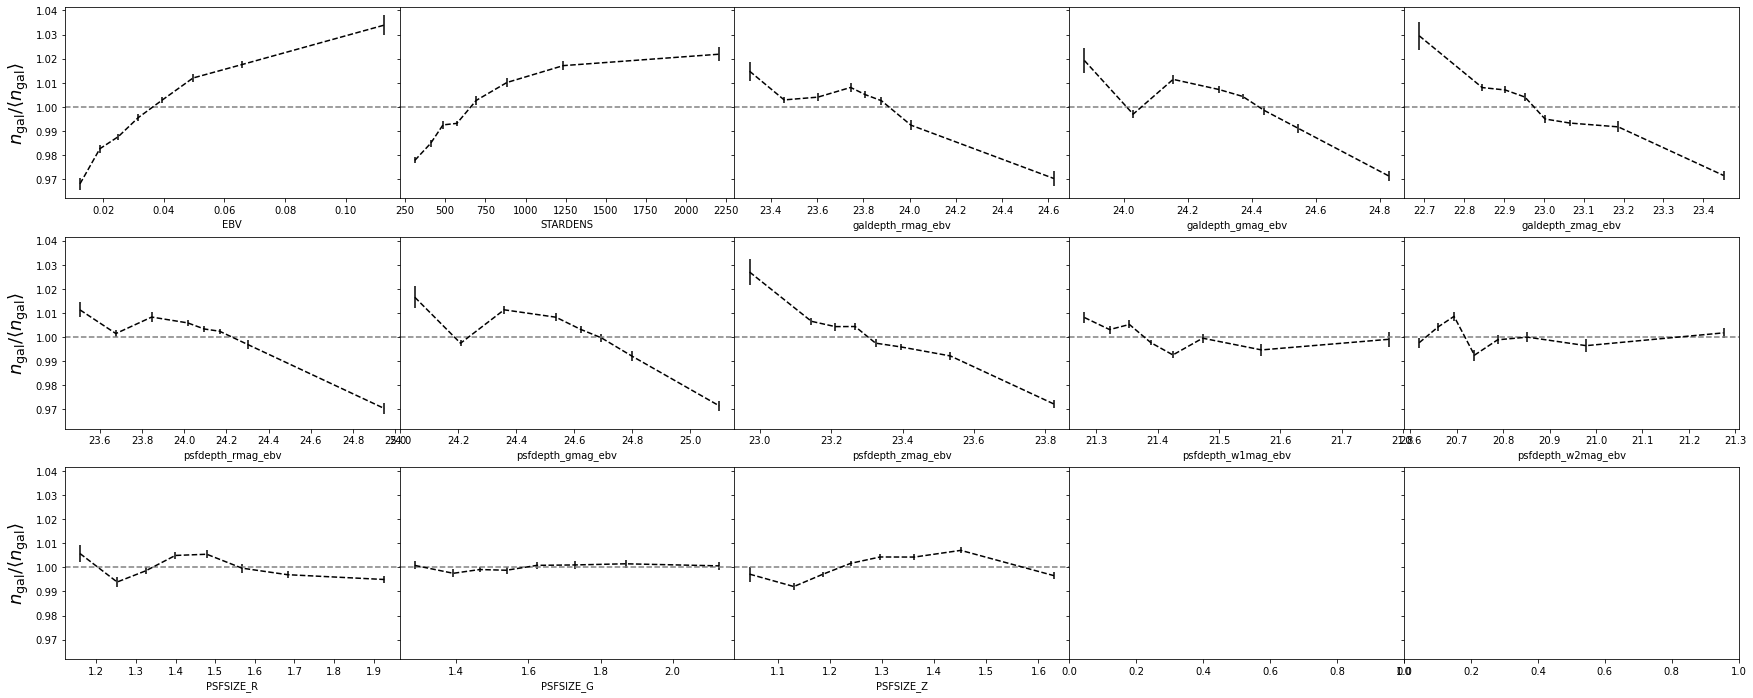

In [27]:
fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
fg.subplots_adjust(wspace=0.0, hspace=0.2)
plt.rc('figure', facecolor='w')
ax = ax.flatten()
ftsize=18

for col_i in range(len(maps)):
    ax[col_i].set(xlabel=f'{maps[col_i]}')
    ax[col_i].errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], ls='--', color='k', label='LRG data')
    #ax[col_i].errorbar(nnbar_list_uncont[col_i]['bin_avg'], nnbar_list_uncont[col_i]['nnbar'], nnbar_list_uncont[col_i]['nnbar_err'], color='k', label='uncont')
    #ax[col_i].plot(nnbar_list_cont[col_i]['bin_avg'], nnbar_list_cont[col_i]['nnbar'], color='r',ls='--', label='cont (downsampled)')
    #ax[col_i].legend(title=f'{zmin} < z < {zmax}')
    ax[col_i].axhline(y=1., color='gray', ls='--')
ax[0].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[5].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
ax[10].set_ylabel('$n_{\\mathrm{gal}}/\\langle n_{\\mathrm{gal}} \\rangle$',fontsize=ftsize)
#ax[0].set_ylim(1.00-0.2, 1.00+0.2)
#fn = os.path.join(plot_dir, f'LRG_density_variations.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)

plt.show()